In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import optimize

https://stackoverflow.com/questions/78637026/how-to-choose-the-best-fitting-method

In [18]:
def fitfunction(list, maxiter, error_threshold):
    
    v = 1.4
    st = 5
    exp_v = np.exp(-1/v)
    x00 = np.array([(np.pi/(4*v))*i**(-2) for i in list])
    lm = 1000
    
    def mse(y_true, y_pred):
        mse_value = sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)) / len(y_true)
        return mse_value
    
    def fast_roll_add(dst, src, shift):
        dst[shift:] += src[:-shift]
        dst[:shift] += src[-shift:]
    
    # Main function
    def fp(x, L, v):
        n = len(x)
        y = np.zeros(n)
        last_exp_2_raw = np.zeros(n)
        last_exp_2 = np.ones(n)
        unitary = x.copy()
        for k in range(L+1):
            if k != 0:
                fast_roll_add(unitary, x, k)
                fast_roll_add(unitary, x, -k)
            exp_1_raw = last_exp_2_raw
            exp_1 = last_exp_2
            exp_2_raw = exp_1_raw + unitary / v
            exp_2 = np.exp(-exp_2_raw)
            y += (exp_1 - exp_2) / unitary
            last_exp_2_raw = exp_2_raw
            last_exp_2 = exp_2
        return y

    # Fitting functions
    def fitf(time, lst, x0, j):
        return x0[j] * (lst[j] / time[j])**2
    
    def cfit(time, lst, x0):
        result = np.empty_like(x0)
        for j in range(len(x0)):
            if fitf(time, lst, x0, j) < 10**(-20):
                result[j] = 10**(-20)
            elif abs(time[j] - lst[j]) < .5:
                result[j] = x0[j]
            else:
                result[j] = fitf(time, lst, x0, j)
        return result
    
    xs = x00
    ys = fp(xs, len(xs)//st, v)
    err = 10**10
    
    def objective(x):
        xs = cfit(x, ys, xs) # Fitting
        ys = fp(xs, len(xs)//st, v) # Update function values
        err = mse(x[lm:-lm], ys[lm:-lm])
        return err
    
    for j in range(maxiter):
        if err > error_threshold:
            xs = cfit(list, ys, xs) # Fitting
            ys = fp(xs, len(xs)//st, v) # Update function values
            err = mse(list[lm:-lm], ys[lm:-lm])
            print(str(j+1) + '/' + str(maxiter) + ' err: ' + str('{:.20f}'.format(err)), end="\r")            
        else:
            break

    fire_rates = ['{:.20f}'.format(i) for i in xs]
    time_sim = ys
    
    return [fire_rates, time_sim]

In [17]:
# Data generation
np.random.seed(18)
data = np.random.normal(loc=0, scale=10, size=10000).cumsum()
data = (data - data.min()) / (data.max() - data.min()) * 500

# Gaussian smoothing
data = gaussian_filter1d(data, sigma=100)

In [4]:
data_fit = fitfunction(data, 100, 2)

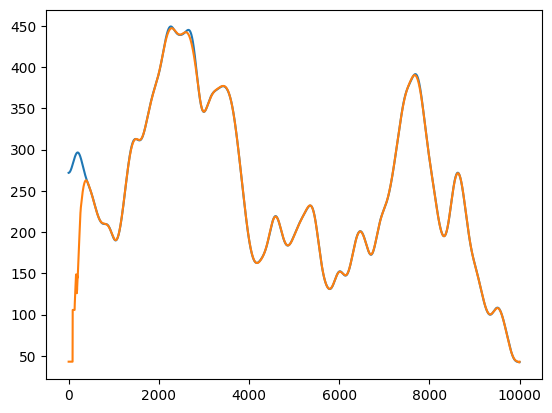

In [16]:
fig, axe = plt.subplots()
axe.plot(data)
axe.plot(data_fit[1])

In [44]:
class Solver:
    
    def __init__(self, x):
        self.x = x
        self.v = 1.4
        self.st = 5
        self.exp_v = np.exp(-1. / self.v)
        self.x00 = np.array([( np.pi / ( 4 * self.v)) * np.power(i, -2.) for i in self.x])
        self.lm = 1000

    @staticmethod
    def fast_roll_add(dst, src, shift):
        dst[shift:] += src[:-shift]
        dst[:shift] += src[-shift:]

    @staticmethod
    def fp(x, L, v):
        n = len(x)
        y = np.zeros(n)
        last_exp_2_raw = np.zeros(n)
        last_exp_2 = np.ones(n)
        unitary = x.copy()
        for k in range(L + 1):
            if k != 0:
                Solver.fast_roll_add(unitary, x, k)
                Solver.fast_roll_add(unitary, x, -k)
            exp_1_raw = last_exp_2_raw
            exp_1 = last_exp_2
            exp_2_raw = exp_1_raw + unitary / v
            exp_2 = np.exp(-exp_2_raw)
            y += (exp_1 - exp_2) / unitary
            last_exp_2_raw = exp_2_raw
            last_exp_2 = exp_2
        return y

    @staticmethod
    def fitf(time, lst, x0, j):
        return x0[j] * (lst[j] / time[j])**2
    
    @staticmethod
    def cfit(time, lst, x0):
        result = np.empty_like(x0)
        for j in range(len(x0)):
            if fitf(time, lst, x0, j) < 10**(-20):
                result[j] = 10**(-20)
            elif abs(time[j] - lst[j]) < .5:
                result[j] = x0[j]
            else:
                result[j] = fitf(time, lst, x0, j)
        return result
    
    @staticmethod
    def mse(y_true, y_pred):
        mse_value = sum((yt - yp) ** 2 for yt, yp in zip(y_true, y_pred)) / len(y_true)
        return mse_value     
        
    def factory(self):
        
        xs = self.x00
        ys = fp(xs, len(xs) // self.st, self.v)
        
        def wrapper(p):
        
            xs = self.cfit(p, ys, xs)
            ys = self.fp(xs, len(xs) // self.st, self.v)
            err = self.mse(self.x[self.lm:-self.lm], ys[self.lm:-self.lm])
            return err
        
        return wrapper
        

In [45]:
solver = Solver(data)

In [46]:
optimize.minimize(solver.factory(), x0=data)

UnboundLocalError: local variable 'ys' referenced before assignment